
# Language Model for Tamil - Built from entire Tamil Wikipedia

First Draft: Ravi Annaswamy April 6, 2019.


## What is a Language Model?

What is a Model, first of all? A model is a organized knowledge-store that can help predict what will happen in various situations. 

Model of the solar system helps  us predict when will Sun rise at a given place on globe on a given day.

A language model, similarly helps predict what word will come next in a sequence of words. This is done by the model systematically learning what usually comes in a context. 


## Why is it needed?

Humans interpret what is being said, because they have the mental model of the language. That is how we know that 'dog bites a man' is different from 'man bites a dog'.

Understanding speech in a noisy room, finding and fixing spelling mistakes, and grammatical mistakes are immediate obvious uses of a language model. But it goes more than that. ALL OUR COMMUNICATION is noisy and partial statement, and it is made possible because listener fills in the gaps (reads between lines) because of the language and world model he shares with the speaker or writer.

## How do we build a language model?

Pre-2010 ngram models were the state of the art. An ngram (say a three word phrase) serving as a context and a table showing what all words followed it how many times in a large text, serves as a prediction model.

With Deep learning, several breakthroughs happened in this field. 

First, words are mapped to meaning vectors in a continuous space so generalization becomes vastly easy. 

Secondly the system can figure out contexts that are optimal and useful.

Third, GPU computing, wikipedia, deep learning libraries such as tensorflow, keras, pytorch and fastai have made doing this a piece of cake.

As you will see, we can build a state of the art language model for any language in less than four hours, from collecting text, to tokenizer construction to language model. This is a miracle.

Also, even though these are termed as language models, they go beyond just figuring out the grammar (syntax), they also recognize patterns in usage, semantics, so they are a model of the world to the extent it can be inferred from the language. This is why recent recognition that language models with very little fine tuning can be used for question answering and other natural language tasks that are not linguistic but real-world tasks.


This code is adapted from https://github.com/goru001/nlp-for-hindi/blob/master/language-model/Hindi_Language_Model.ipynb

Modifications for tamil:

- Chose to use 8000 word vocabulary for Sentence Piece.

- Perplexity of ~20 when trained on 120,000 articles.

- Updated the text generator section with a slightly better probing function.


# Part I. Get the Tools

## Step 1. Install fastai Deep Learning Library

In [1]:
!pip install fastai --upgrade

  Using cached https://files.pythonhosted.org/packages/44/cc/dcc702cf43bb8c908d172e5be156615928f962366a20834c320cbca2b9d0/fastai-1.0.51-py3-none-any.whl
  Found existing installation: fastai 1.0.50.post1
    Uninstalling fastai-1.0.50.post1:
      Successfully uninstalled fastai-1.0.50.post1
  Rolling back uninstall of fastai
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/opt/anaconda3/lib/python3.7/site-packages/fastai/__init__.py'
Consider using the `--user` option or check the permissions.



## Step 2. Import necessary modules.

In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.50.post1', '1.0.1.post2')

## Step 3. Turn on GPU support.

In [4]:
torch.cuda.set_device(0)

# Part II. Get data.

## Step 4. Get list of text files for training, and create validation subset of 20%

In [4]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-tamil/language-model/')

### change the following to tawiki_small if you want to train on all 12000 articles. The small one here is a subset of 40000 articles for quick testing.

In [ ]:
p = path.glob('../corpus/tawiki/tawiki_large/*/*.txt')
files = [str(x) for x in p if x.is_file()]
len(files)

## Please note: if you want to quick experiment on this data to get a feel for the code, please choose a smaller subset of files.
 you can modify the following line to choose only 20 of the 447 files.
 
 train_files, test_files = train_test_split(files*[:20]*, test_size=0.2)

In [10]:
train_files, test_files = train_test_split(files, test_size=0.2)

In [11]:
len(train_files), len(test_files)

(357, 90)

In [12]:
def get_article_count(filelist):
  AC=0
  for f in filelist:
    with open(f, encoding='utf-8') as fp:
      text=fp.read()
      AC+=text.count('<doc id')
  return AC

In [13]:
get_article_count(train_files), get_article_count(test_files)

(102126, 25255)

## Step 5. Copy files from tamil wiki into train and valid folders

In [14]:
!mkdir TamilWikiDataset
!mkdir TamilWikiDataset/train
!mkdir TamilWikiDataset/valid

In [15]:
# Preparing dataset for fastai
for file in train_files:
    with open(file, encoding='utf-8') as f:
        text = f.read()
    with open(path/'TamilWikiDataset'/'train'/(str(file).split('/')[-1]), "w") as text_file:
        text_file.write(text)

In [16]:
for file in test_files:
    with open(file, encoding='utf-8') as f:
        text = f.read()
    with open(path/'TamilWikiDataset'/'valid'/(str(file).split('/')[-1]), "w") as text_file:
        text_file.write(text)

In [17]:
#!zip -r train.zip TamilWikiDataset/train

In [18]:
#!zip -r valid.zip TamilWikiDataset/valid

# Part III. Setup learner

## Step 6. Define Tamil Tokenizer by wrapping our SP model. 

#### We are creating a tokenizer that will use the rules from the sentencepiece model, to split each sentence into its root parts.

In [19]:
#class TamilTokenizer(BaseTokenizer):
#    def __init__(self, lang:str):
#        self.lang = lang
#        self.sp = spm.SentencePieceProcessor()
#        self.sp.Load(str("tamil_spm_8k.model"))
#        
#    def tokenizer(self, t:str) -> List[str]:
#        return self.sp.EncodeAsPieces(t)

### I am placing this inside inltk package, to allow inltk to use this tokenizer

In [5]:
from inltk.tokenizer import TamilTokenizer

In [6]:
sp = spm.SentencePieceProcessor()
sp.Load(str('tamil_spm_8k.model'))
itos = [sp.IdToPiece(int(i)) for i in range(8000)]

In [7]:
tamil_vocab = Vocab(itos)

In [8]:
tokenizer = Tokenizer(tok_func=TamilTokenizer, lang='ta')

In [9]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [10]:
path

PosixPath('/home/gaurav/PycharmProjects/nlp-for-tamil/language-model')

## Step 7. Create Fast AI Data generator from the train and valid paths.

In [16]:
data_lm = TextLMDataBunch.from_folder(path=path/'TamilWikiDataset', tokenizer=tokenizer, vocab=tamil_vocab)

In [17]:
data_lm.batch_size

64

In [27]:
data_lm.save('data_lm_tawiki_8k.pkl')

In [18]:
data_lm.show_batch()

idx,text
0,"நோ யாகும் . ▁இது ▁முதற் கல வு ரு ▁ஒட்டு ண்ணி கள் ▁மூலம் ▁ஏற்படுகிறது . ▁அமெரிக்கா , ▁ஆசியா ▁மற்றும் ▁ஆப்பிரிக்கா ▁ஆகிய ▁பகுதி களையும் ▁சேர்த்து ▁வெப்ப ▁வலய ம் ▁சார்ந்த ▁மற்றும் ▁மித வெப்ப ▁மண்டல ▁பிரதேச ங்களிலும் ▁இது ▁பரவலாக க் ▁காணப்படுகிறது . ▁ஒவ்வொரு ▁ஆண்டு ம் ▁தோராயமாக ▁3 50 ▁முதல் ▁500 ▁மில்லியன் ▁வரையிலான ▁மக்கள் ▁ம லே ரியா ▁நோ யினால் ▁பாதிக்கப்பட ுகிறார்கள் . ▁அவற்றில் ▁ஒன்ற ிலிருந்து ▁மூன்று ▁மில்லியன் ▁மக்கள் ▁இந்த ▁நோ யினால் ▁இறக்க ிறார்கள் ."
1,". ▁இத்த ெ ரு வில் ▁நடக்கும் ▁அன்றாட ▁நிகழ்வு களை ▁அடிப்படையாக ▁வைத்து , ▁வெளிவந்த ▁திரைப்பட மே , ▁அ ங்கா டி த் ▁தெரு ▁ஆகும் . ▁< ▁ / ▁ doc > ▁< doc ▁id ="" 14 93 09 "" ▁ url ="" https : ▁ / ▁ / ▁ ta . wikipedia . org ▁ / ▁ wiki ? curi d = 14 93 09 "" ▁title ="" ரோ சா ப்பூ"
2,"டன் ▁வெற்றிகரமான ▁அறுவடை ▁மேற்கொள்ள ப்படுகிறது . ▁அவரை க் ▁குடும்ப த் ▁தாவர ங்களைச் ▁' சு ழற்சி முறை ' ப் ▁பயிர் களாகப் ▁பயன்படுத்திய மை யே ▁இவ் ▁வெற்றி க்குக் ▁காரணமாக ும் . ▁மேலும் , ▁சென்ற ▁பதி ற்ற ாண்ட ில் , ▁க னோ லா ▁வகை த் ▁தாவர த்தை ▁சுழற்சி முறை ப் ▁ப யிர ாகப் ▁பயன்படுத்திய தின் ▁விளைவாக ▁கோதுமை ▁விளை ச்சல் ▁25 % ▁அதிகரித்த ுள்ளது . ▁மழை வீ ழ் ச்சி ▁குறைந்த ▁இப் பிரதேச ங்களில்"
3,"ப் ▁பெற்றார் . ▁நிறைய ▁போட்டிகளில் ▁விளையாடிய ▁பிற கே ▁தனது ▁முதல் ▁தேர்வுத் ▁துடுப்பாட்ட ▁"" கே ட் சை ப் "" ▁பிடித்த ார் . ▁அக்டோபர் ▁31 , ▁2016 ▁இல் ▁மேற் கி ந்திய த்தீவு கள் ▁துடுப்பாட்ட ▁அணிக்கு ▁எதிரான ▁தனது ▁20 ▁ஆவது ▁தேர்வு ப் ▁போட்டியில் ▁டே ரன் ▁பிரா வோ ▁அடி த்த ▁ப ந்தை ▁அற்புத மாக ப் ▁பிடித்து ▁அவரை ▁வீழ்த்த ▁உதவி னார் . ▁2010 ▁ஆம் ▁ஆண்டில் ▁ஆத்திரேலிய த் ▁துடுப்பாட்ட ▁அணிக்கு ▁எதிரான ▁பன்னாட்டு ▁இருபது 20 ▁போட்டியில்"
4,"மான <unk> <unk> h e <unk> <unk> r u t h <unk> ▁b o o k ▁ யெ கோ வா வின் ▁ச ாட்சி ▁ கள் ▁"" , ம த்தி யில் ▁து ஷ் பிர யோ கம் ▁செய்யப்பட்டு ▁தப்பி த்து ▁வந்த ▁ஒரு ▁குழந்தை யின் ▁உண்மை க்கதை யாக ▁2005 ▁ஆம் ▁ஆண்டு ▁வெளியிடப்பட்டது . ▁இது ▁தவிர ▁கவிதைகள் ▁மற்றும் ▁சிறு ▁கதை களையும் <unk> <unk> ell ▁ or <unk> <unk> ig h <unk> ▁w at"


In [19]:
len(data_lm.vocab.itos)

8000

## Step 8. Create a LM Learner object and run it once to estimate good learning rate.

In [8]:
data_lm = load_data('TamilWikiDataset', 'data_lm_tawiki_8k.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'TamilWikiDataset/data_lm_tawiki_8k.pkl'

In [20]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, pretrained=False)

In [21]:
gc.collect()

674

# Part IV. Train.

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


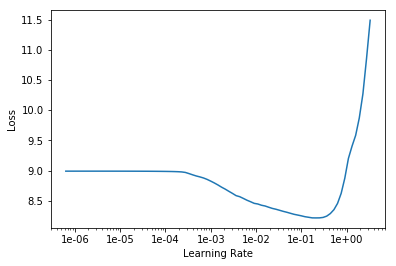

In [34]:
learn.recorder.plot()

## Step 9. Fit one cycle using an appropriate learning rate and save the model if you like it.

In [35]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.890449,3.762490,0.357238,1:00:35


In [36]:
learn.save('wikita_8k_447_first', with_opt=True)

In [37]:
learn.load('wikita_8k_447_first', with_opt=True);

In [38]:
np.exp(3.7624)

43.05162599159145

## Step 10. Now fit a few more cycles.

In [39]:
learn.unfreeze()

In [40]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.682452,3.898896,0.341597,1:00:19
1,3.829053,3.884494,0.342567,1:00:05
2,3.478386,3.672344,0.366506,1:00:14
3,3.480849,3.440922,0.394125,1:00:10
4,3.475762,3.332312,0.406661,1:00:11


In [41]:
learn.save('wikita_8k_447_second', with_opt=True)

In [16]:
learn.load('wikita_8k_447_second', with_opt=True);

## Step 11. Finally, with smaller learning rate fine tune the model for lot more iterations.

In [42]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.273025,3.223268,0.500000,55:32
1,3.241727,3.258525,0.514286,55:29
2,3.188190,3.144011,0.500000,55:36
3,3.239507,3.027930,0.528571,55:37
4,3.316402,3.049245,0.514286,55:37
5,3.221811,3.049403,0.514286,55:43
6,3.225265,3.028381,0.528571,55:39
7,2.759860,2.986449,0.514286,55:45


KeyboardInterrupt: 

In [43]:
learn.save('wikitalm_8k_447_third', with_opt=True)

In [22]:
learn.load('wikitalm_8k_447_third', with_opt=True);

## Step 12. Calculate perplexity of the language model.

In [45]:
np.exp(2.986)

19.806298635156402

## Step 13. Probe the LM by asking it to complete phrases.



In [46]:
def create(text, spm=False, N_WORDS=50, N_SENTENCES=4):
    TEXT=sp.EncodeAsPieces(text)
    TEXT=' '.join(TEXT)
    sp_merge=lambda s:s.replace(' ','').replace('▁',' ')
    samples=[]
    for _ in range(N_SENTENCES):
      sample=learn.predict(TEXT, N_WORDS, temperature=0.7)
      samples.append(sample)
      if spm:
          print(sample)
          print()
    if spm:
        print()
    for sample in samples:
      sample=sp_merge(sample)
      print(sample)
      print()
    


In [47]:
text='17-ஆம் நூற்றாண்டில்'
create(text, spm=True)

▁17 - ஆம் ▁நூற்றாண்டில் ▁முதல் ▁உலகப் போர் ▁முடிவடைந்த து . ▁தனது ▁ஆட்சி க் ▁காலத்தில் ▁பிரான்சின் ▁அரசு த்தலைவர் ▁ மன் ஹா ட்டன் ▁ஒரு வரை த் ▁தேர்ந்தெடுத்த ு , ▁சோ தி க்க ▁வேண்டிய ▁பொறுப்பு ம் ▁ஆ க்கப்பட்டு , ▁நாட்டின் ▁பொருளாதார த்தைக் ▁கொண்டுவர வும் , ▁தமது ▁கட்டிட ங்களை ▁மாற்றி க்கொள்ள வும் ▁முயற்சி ▁செய்தார் . ▁அதனால் , ▁அவர்

▁17 - ஆம் ▁நூற்றாண்டில் ▁ டெல் டா ▁எனும் ▁இடத்தில் ▁ஒரு ▁குடியிருப்பு ப் ▁பகுதியில் ▁உள்ளது . ▁இந்த ▁ஊர் ▁7 000 ▁சதுர ▁அடி ▁பரப்ப ள விற்கு ▁மேல் ▁அமைந்துள்ளது . ▁இங்கு ▁5 000 ▁அடி ▁உயர முள்ள ▁இந்த ▁கோவில ும் , ▁கி றி ஸ் து வ ▁மத த்தின் ▁ஒரு ▁பகுதியாக வும் ▁உள்ளது . ▁< ▁ / ▁ doc

▁17 - ஆம் ▁நூற்றாண்டில் , ▁ பிரான் சில் ▁உள்ள ▁ ஃபோர்ட் ▁பிரா ங்க் ளின் , ▁டெ ன் ▁மற்றும் ▁" இ . அ . கா ம் " ▁என்ற ▁இரு தி ட க் ▁கூறு களை ▁கொண்டு , ▁இ க்கட்ட ளை ▁ கியூ ரி யின் ▁அ கு ஸ் தா க் ▁யோ ச னை யில் ▁அமைந்துள்ள ▁ஒரு ▁ஸ்

▁17 - ஆம் ▁நூற்றாண்டில் ▁ வல் கன் ▁ ரன் ▁எனக் ▁கருதப்பட்ட னர் . ▁அ ம் ரி த் சர் , ▁லி ஹி லியா , ▁வெ னி சு லா , ▁லி சி யே சி யே ▁ஆகும் . ▁இது ▁எ த்தி யோ ப் பியா 

In [48]:
create('இந்த கிராமத்தில்')

 இந்த கிராமத்தில் வாழும் வாழ்க்கையைப் பின்பற்றியவர்கள். இதற்கு மாற்றாக, பொது மக்கள் அனைவரும் இதைப் பயன்படுத்த வேண்டும் என்ற கொள்கையை உடையவர்களாக இருந்தனர். இந்த விளைவைத் தோழமை செய்யும் வகையில், ஒரு தொழில் நுட்பம், மற்றும் பரந்த கிராமப்புறங்கள், பாறைகள் போன்றவற்றைக் கொண்டு அமைக்கப்பட்டிருக்கும்

 இந்த கிராமத்தில், ஆங்கராவின் வழிவந்தோர் புலிகள் ஆகும். இது ஒரு ஆன்மிகப் புகழ்ச்சி ஆகும். இதன் மூலம் மனிதனைப் பெண்களால் உருவாக்கலாம். பலவகையான உடல் முறைகளை உட்கொண்டு, உடலைப் பொருத்தி, விலங்குகளின் உடலில் இருந்து

 இந்த கிராமத்தில் பகுக்கப்பட்டுள்ளது, மற்றும் பல மக்களின் மேம்பாட்டிற்காகவும் அழகு படுத்தப்படுகிறது. < / doc> <doc id="323593" url="https: / / ta.wikipedia.org / wiki?curid

 இந்த கிராமத்தில் உள்ள ஒரு கிராமம். அக்கோடிடே, அய்லி, அயன், நயனை, நாகாலா, சபிசி, சிரினா, விதாவகி, எமரு, வசித்தி, யேரா போன்ற ச



In [49]:
create('1995 ம் ஆண்டு முதல் 2000 வரை')

 1995 ம் ஆண்டு முதல் 2000 வரை. எஃப்.எசு. ஹால்ஸ் மற்றும் ஜெர்ரி வாட்டர்ஸ் ஆகியோரால் கண்டுபிடிக்கப்பட்ட இப்புத்தகத்தடத்திலிருந்து எடுக்கப்பட்ட அறிமுறை முன்னூகிக்கும் ஒருவகைப் பெயர். இந்த ஒரே மாதிரியான அனைத்து ஆர்.எஸ்.

 1995 ம் ஆண்டு முதல் 2000 வரை கொந்தளிப்புகள், குத்துயரங்கள், பாக்குகள், ட்ரெத்கள் மற்றும் ரைன்டர்கள் என பலவகையான மொழிகளைப் பயன்படுத்தினர். இவர்கள் லத்தீன் பேசியவர்கள். ஆனாலும், நவீன பிரெஞ்சுக்காரர்கள்

 1995 ம் ஆண்டு முதல் 2000 வரை மாட்டுநடுவிலும், லைப்னிட்ஸ், பூர்ட் (மருந்து) , பிரதிஷ்டை , புர்காம் , ஹவாய் வடக்கு , கச டுவாட் நில்சௌ டுரூ

 1995 ம் ஆண்டு முதல் 2000 வரை இது நிகழ்ந்துள்ளது. அந்தச் சமயத்தில் மாற்றம் அடைந்து வெளிநாடுகளில் இருந்து வெளியேறியதால் பல லட்சம் பேர் இறந்தனர். இந்த நாள் விக்டோரிய மக்கள் தொகைக் கணக்கெடுப்புகளில் 5.6 சதவீதமானோர் இங்கு வந்து குடியேறியுள்ளனர். இவர்களில் பெரும்பான்மையானோர் 85



In [ ]:
create('இந்த விபத்தில் ')

## Step 14. Prompt it to write entirely imagined new Wiki Articles. 

In [ ]:
create('<doc id="208219" url="https://ta.wikipedia.org/wiki?curid=', N_WORDS=200, N_SENTENCES=10)

## 

- Next steps
- Try the same notebook for another language
- Try Transformer, Transformer XL, GPT-2
- Explore the LM
- Test out the LM on classification 

In [23]:
learn.export('export.pkl')

In [11]:
# Generating embedding vectors for visualization

In [12]:
path

PosixPath('/home/gaurav/PycharmProjects/nlp-for-tamil/language-model')

In [13]:
defaults.device = torch.device('cpu')

In [14]:
learn = load_learner(path / 'TamilWikiDataset/')

In [15]:
encoder = get_model(learn.model)[0]

In [16]:
encoder.state_dict()['encoder.weight'].shape

torch.Size([8000, 400])

In [17]:
embeddings = encoder.state_dict()['encoder.weight']

In [18]:
embeddings = np.array(embeddings)

In [19]:
embeddings[0].shape

(400,)

In [20]:
df = pd.DataFrame(embeddings)

In [21]:
df.shape

(8000, 400)

In [22]:
df.to_csv('embeddings.tsv', sep='\t', index=False, header=False)

In [23]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,-0.174485,-0.210578,0.370564,0.494773,-1.110023,0.890757,-0.033308,-0.735920,-1.146442,0.458800,...,-0.454304,-0.374571,-0.124457,-0.055464,-0.280727,-0.431140,-0.672921,-1.271594,-0.043097,-0.599503
1,-0.213150,-0.035730,0.059510,0.149528,-0.792459,0.303528,-0.088352,-0.177186,-0.352764,-0.020687,...,-0.276393,-0.229400,-0.175280,-0.035048,-0.108500,-0.268964,-0.514922,-0.399817,0.074859,0.080948
2,-0.212688,-0.034252,0.060038,0.150189,-0.794856,0.308804,-0.089119,-0.174016,-0.351749,-0.024862,...,-0.268096,-0.227708,-0.173513,-0.035063,-0.106040,-0.262310,-0.512204,-0.407283,0.076857,0.083062
3,-0.349795,-0.123294,-0.079460,0.123450,-1.105836,0.536652,0.473493,-1.475997,0.491273,0.673826,...,-1.970096,0.177332,-0.123421,0.116869,-0.554221,-0.926728,-0.591517,0.937839,-0.498299,0.184174
4,0.039110,-0.164002,0.819677,-0.087105,-0.942842,0.033881,-0.013632,-0.892259,-0.540784,0.683643,...,-1.916319,-0.108441,-0.095604,0.084792,-0.307459,-0.819997,-0.508193,-0.398217,-0.093950,0.101915


In [24]:
df2 = pd.DataFrame(itos)

In [25]:
df2.head()

,0
0,<unk>
1,<s>
2,</s>
3,.
4,","


In [26]:
df2.shape

(8000, 1)

In [27]:
df2.to_csv('embeddings_metadata.tsv', sep='\t', index=False, header=False)

In [28]:
encoder.state_dict()['encoder.weight'][1]

tensor([-2.1315e-01, -3.5730e-02,  5.9510e-02,  1.4953e-01, -7.9246e-01,
         3.0353e-01, -8.8352e-02, -1.7719e-01, -3.5276e-01, -2.0687e-02,
         7.0271e-01, -1.4703e-01,  7.4531e-02,  6.2223e-01, -8.9148e-02,
        -3.2697e-01,  2.4841e-01,  1.4575e-02,  2.3894e-01, -5.1608e-01,
         2.4632e-01,  2.7786e-01, -5.1374e-01,  3.7280e-01,  1.6988e-01,
         7.8987e-02,  8.2155e-02, -6.9644e-01,  5.5053e-01,  3.0106e-01,
         5.7335e-01, -8.3915e-01,  2.7960e-01, -3.7256e-01, -5.5981e-01,
        -4.3901e-01, -1.9851e-01,  4.2656e-01, -8.9112e-02,  3.2256e-01,
        -2.2972e-01,  2.2242e-01, -8.1922e-01, -1.9095e-01, -3.8355e-01,
        -6.4462e-01,  7.5018e-01,  4.4044e-01, -4.2676e-02, -5.5288e-01,
         4.7536e-03, -5.3245e-01,  6.0183e-01,  3.5407e-02, -7.9027e-02,
         1.9987e-01, -5.0119e-01, -7.1134e-02,  1.7056e-01, -8.6089e-02,
         2.2013e-02, -4.0169e-01, -7.8194e-02, -6.0169e-01, -2.7248e-01,
         1.1653e+00, -4.4544e-01,  5.3275e-01,  6.0